In [77]:
import pytz
import os
from datetime import datetime, timedelta
import pandas as pd
from pandas.tseries.offsets import MonthBegin
import urllib2
import cPickle
from sunpy.time import TimeRange
from sunpy.instr import goes
from sunpy.net import hek
client = hek.HEKClient()

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
sns.set_style("white")

In [22]:
date_values = pd.date_range(pd.Timestamp('2011-03-01').tz_localize('utc'), 
                          pd.Timestamp('2016-09-01').tz_localize('utc'),  freq='MS')
directory = 'AR-FL/'

# Group all data from GOES

In [24]:
%%time
goes_data_all = pd.DataFrame()
for d in xrange(len(date_values) - 1):
    # Get FL data from GOES
    goes_data = pd.DataFrame.from_csv('{0}GOES-FL-{1}.csv'.format(directory, str(date_values[d].to_period('M'))))
    goes_data_all = goes_data_all.append(goes_data, ignore_index=True)
#     print "Done FL, {0}".format(str(date_values[d].to_period('M')))

def get_value_flux(x):
    x = float(x.replace(' W / m2', ''))
    return x
goes_data_all['flux_value'] = goes_data_all.flux.apply(lambda x: get_value_flux(x))

CPU times: user 1.44 s, sys: 8 ms, total: 1.44 s
Wall time: 1.44 s


In [25]:
goes_data_all[:3]

,ar_noaanum,event_starttime,event_peaktime,event_endtime,fl_goescls,obs_instrument,obs_title,event_coord1,event_coord2,boundbox_c1ll,...,hpc_geom,hpc_radius,hpc_x,hpc_y,hrc_a,hrc_bbox.1,hrc_boundcc.1,hrc_coord.1,hrc_r,flux
0,0,2011-02-28T23:11:00,2011-03-01T00:05:00,2011-03-01T00:27:00,C1.6,GOES,NaN,0,0,-90.0,...,NaN,122.08080,0.0000,122.0808,0.000000,"POLYGON((0.992672 180.000005,0.992672 179.9999...",NaN,POINT(0.126117407057152 0),0.126117,1.6e-06 W / m2
1,11164,2011-03-01T02:30:00,2011-03-01T04:13:00,2011-03-01T04:40:00,C6.0,GOES,NaN,-32,24,-32.5,...,010300000001000000050000002C431CEBE2E27FC0EA04...,676.49323,-470.1804,486.3882,44.029291,"POLYGON((0.69917 45.001724,0.690401 44.139741,...",NaN,POINT(0.698885398933439 44.0292910687973),0.698885,6e-06 W / m2
2,11164,2011-03-01T08:52:00,2011-03-01T09:18:00,2011-03-01T09:34:00,C2.9,GOES,NaN,0,0,-90.0,...,NaN,122.15460,0.0000,122.1546,0.000000,"POLYGON((0.992666 180.000005,0.992666 179.9999...",NaN,POINT(0.126206254932862 0),0.126206,2.9e-06 W / m2


In [28]:
goes_data_all_with_AR = goes_data_all[goes_data_all.ar_noaanum!=0]
goes_data_all_with_AR[:3]

,ar_noaanum,event_starttime,event_peaktime,event_endtime,fl_goescls,obs_instrument,obs_title,event_coord1,event_coord2,boundbox_c1ll,...,hpc_radius,hpc_x,hpc_y,hrc_a,hrc_bbox.1,hrc_boundcc.1,hrc_coord.1,hrc_r,flux,flux_value
1,11164,2011-03-01T02:30:00,2011-03-01T04:13:00,2011-03-01T04:40:00,C6.0,GOES,NaN,-32,24,-32.5,...,676.49323,-470.1804,486.3882,44.029291,"POLYGON((0.69917 45.001724,0.690401 44.139741,...",NaN,POINT(0.698885398933439 44.0292910687973),0.698885,6e-06 W / m2,0.000006
2,11164,2011-03-01T08:52:00,2011-03-01T09:18:00,2011-03-01T09:34:00,C2.9,GOES,NaN,0,0,-90.0,...,122.15460,0.0000,122.1546,0.000000,"POLYGON((0.992666 180.000005,0.992666 179.9999...",NaN,POINT(0.126206254932862 0),0.126206,2.9e-06 W / m2,0.000003
3,11164,2011-03-01T14:35:00,2011-03-01T14:38:00,2011-03-01T14:40:00,C1.1,GOES,NaN,0,0,-90.0,...,122.19540,0.0000,122.1954,0.000000,"POLYGON((0.992656 180.000005,0.992656 179.9999...",NaN,POINT(0.126255872178124 0),0.126256,1.1e-06 W / m2,0.000001


In [52]:
goes_data_all_with_AR['day_event_peaktime'] = goes_data_all_with_AR.event_peaktime.apply(lambda x: pd.Timestamp(x).to_period('D'))
goes_data_all_with_AR[['ar_noaanum', 'event_peaktime', 'day_event_peaktime']][:3]

/home/norman/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,ar_noaanum,event_peaktime,day_event_peaktime
1,11164,2011-03-01T04:13:00,2011-03-01
2,11164,2011-03-01T09:18:00,2011-03-01
3,11164,2011-03-01T14:38:00,2011-03-01


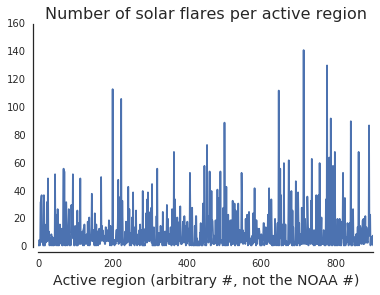

In [88]:
fl_count_per_ar = goes_data_all_with_AR.groupby(['ar_noaanum'])[['flux_value']].count()
fl_count_per_ar.columns = ['n_flares']
fl_count_per_ar = fl_count_per_ar.reset_index().drop(['ar_noaanum'], axis=1)
ax = fl_count_per_ar.plot(kind='line')
plt.xlabel('Active region (arbitrary #, not the NOAA #)',size=14)
plt.title('Number of solar flares per active region', size=16)
ax.legend_.remove()
sns.despine(offset=5, trim=False)

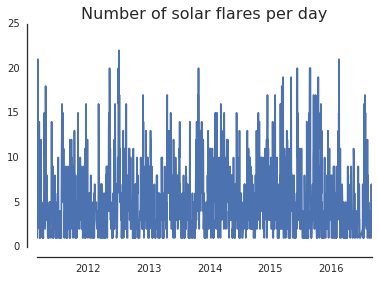

In [87]:
fl_count_per_day = goes_data_all_with_AR.groupby(['day_event_peaktime'])[['flux_value']].count()
fl_count_per_day.columns = ['n_flares']
# fl_count_per_day = fl_count_per_day.reset_index().drop(['ar_noaanum'], axis=1)
ax = fl_count_per_day.plot(kind='line')
plt.xlabel('')
plt.title('Number of solar flares per day', size=16)
ax.legend_.remove()
sns.despine(offset=10, trim=False)

In [56]:
fl_count_per_day[:3]

,n_flares
day_event_peaktime,
2011-03-01,7
2011-03-02,1
2011-03-03,5


In [30]:
goes_data_all_with_AR.groupby(['ar_noaanum'])[['flux_value']].describe()

flux_value
ar_noaanum                    
1283       count  1.000000e+00
           mean   2.100000e-04
           std             NaN
           min    2.100000e-04
           25%    2.100000e-04
           50%    2.100000e-04
           75%    2.100000e-04
           max    2.100000e-04
1290       count  1.000000e+00
           mean   1.400000e-06
           std             NaN
           min    1.400000e-06
           25%    1.400000e-06
           50%    1.400000e-06
           75%    1.400000e-06
           max    1.400000e-06
1771       count  1.000000e+00
           mean   1.000000e-06
           std             NaN
           min    1.000000e-06
           25%    1.000000e-06
           50%    1.000000e-06
           75%    1.000000e-06
           max    1.000000e-06
1775       count  5.000000e+00
           mean   9.620000e-07
           std    3.013636e-07
           min    6.200000e-07
           25%    6.900000e-07
           50%    1.000000e-06
...                        ...
12582      std    7.071068e-09
           min    2.500000e-07
           25%    2.525000e-07
           50%    2.550000e-07
           75%    2.575000e-07
           max    2.600000e-07
12583      count  6.000000e+00
           mean   1.233333e-06
           std    6.250333e-07
           min    3.000000e-07
           25%    1.025000e-06
           50%    1.200000e-06
           75%    1.450000e-06
           max    2.200000e-06
12585      count  8.000000e+00
           mean   9.187500e-07
           std    5.679899e-07
           min    5.100000e-07
           25%    5.500000e-07
           50%    7.300000e-07
           75%    1.025000e-06
           max    2.200000e-06
12657      count  1.000000e+00
           mean   8.400000e-07
           std             NaN
           min    8.400000e-07
           25%    8.400000e-07
           50%    8.400000e-07
           75%    8.400000e-07
           max    8.400000e-07

[7216 rows x 1 columns]

# Group data from SDO

In [ ]:
AR_data_all = pd.DataFrame()
for d in xrange(len(date_values) - 1):
    # Get FL data from GOES
    AR_data = pd.DataFrame.from_csv('{0}SDO-AR-{1}.csv'.format(directory, str(date_values[d].to_period('M'))))
    AR_data_all = AR_data_all.append(AR_data, ignore_index=True)
    print "Done FL, {0}".format(str(date_values[d].to_period('M')))
    